In [1]:
%run setup.ipynb
from matplotlib import gridspec

In [2]:
# regions
region_3L_free = '3L-free', '3L', 15000000, 41000000
region_3R_free = '3R-free', '3R', 1, 37000000

In [3]:
# setup
populations = phase2_ar1.pop_ids
callset_pass = phase2_ar1.callset_pass
callset = phase2_ar1.callset
allele_counts = phase2_ar1.allele_counts
pop_colours = phase2_ar1.pop_colors
df_samples = phase2_ar1.df_samples

In [4]:
%load_ext cython

In [5]:
%%cython
import numpy as np
cimport numpy as np

def pdiff_int32(np.int32_t[:] x):
    cdef:
        np.int32_t[:] d
        Py_ssize_t i, j, k, n, n_pairs
    n = x.shape[0]
    n_pairs = (n * (n - 1)) // 2
    d = np.empty(n_pairs, dtype='i4')
    k = 0
    for i in range(n):
        for j in range(i+1, n):
            d[k] = x[j] - x[i]
            k += 1
    return np.asarray(d)

In [6]:
def collect_ld_distance(pos, gn, n_rep, window_size, window_step=1, permute=False):
    assert pos.shape[0] == gn.shape[0]
    dist = None
    r2 = None
    # calculate expected number of data points
    expectedlen = ((window_size * (window_size - 1)) // 2) * n_rep
    for i in range(n_rep):
        # pick a random index
        start_index = np.random.randint(0, pos.shape[0]-window_size)
        stop_index = start_index + window_size
        posr = np.array(pos[start_index:stop_index:window_step], dtype="int32")
#         log(i, start_index, pos[start_index], pos[stop_index])
        #gnr = np.array(gn[start_index:stop_index:window_step], dtype="int8")
        gnr = gn[start_index:stop_index:window_step]
        if permute:
            for i in range(window_size//window_step):
                gnr[i] = np.roll(gnr[i], i)
        x = pdiff_int32(posr)
        y = allel.rogers_huff_r(gnr)**2
        if dist is None:
            dist = bcolz.carray(x, expectedlen=expectedlen)
            r2 = bcolz.carray(y, expectedlen=expectedlen)
        else:
            dist.append(x)
            r2.append(y)
    return dist[:], r2[:]

In [7]:
def load_genotypes(chrom):
    genotype = allel.GenotypeChunkedArray(callset_pass[chrom]['calldata']['genotype'])
    pos = allel.SortedIndex(callset_pass[chrom]['variants']['POS'][:])
    return pos, genotype

In [8]:
#@functools.lru_cache(maxsize=None)
def snp_ascertainment(chrom, start, stop, pop, min_maf):

    # load genotypes
    pos, genotype = load_genotypes(chrom)
    
    # SNP ascertainment
    ac = allel.AlleleCountsArray(allele_counts[chrom][pop][:])
    
    #compress ac to pass
    pass_boo = callset[chrom]['variants']['FILTER_PASS'][:]
    ac = ac.compress(pass_boo, axis=0)
    
    af = ac.to_frequencies()
    loc_asc = (ac.max_allele() == 1) & (af[:, :2].min(axis=1) > min_maf)
    loc_region = np.zeros(pos.size, dtype='b1')
    loc_region[pos.locate_range(start, stop)] = True
    loc_asc &= loc_region
    logger.debug('SNP ascertainment', chrom, start, stop, pop, nnz(loc_asc))
    
    # extract genotypes for population
    pop_idx = df_samples.population == pop
    
    gt = genotype.subset(sel0=loc_asc, sel1=pop_idx)
    gn = gt.to_n_alt()
    
    return pos[loc_asc], gn

In [9]:
def ld_dist(region, pop, min_maf, n_rep, window_size, window_step, permute):
    logger.debug('window_size', region, window_size)
    _, chrom, start, stop = region
    
    # get genotypes
    pos, gn = snp_ascertainment(chrom, start, stop, pop, min_maf)
    
    # collect LD
    dist, r2 = collect_ld_distance(
        pos, gn, n_rep=n_rep, 
        window_size=window_size, window_step=window_step,
        permute=permute)
    
    return dist, r2

In [10]:
def plot_ld_decay(dist, r2, xmax=2000, xbin=5, baseline=None, title=None, ylim=(0, 1.01)):

    s, e, _ = scipy.stats.binned_statistic(
        dist, r2, statistic=np.mean, bins=np.arange(0, xmax, xbin))
    
    fig, ax = subplots()
    ax.plot(dist, r2, marker=',', linestyle=' ', color='k', alpha=.05)
    x = (e[:-1] + e[1:]) / 2
    y = s
    ax.plot(x, y, marker=' ', linestyle='-', color='r', lw=2)
    ax.set_xlim(0, xmax)
    ax.set_xlabel('distance')
    ax.set_ylim(*ylim)
    ax.set_ylabel('r**2')
    if title:
        ax.set_title(title)
    if baseline:
        ax.axhline(baseline, lw=2, color='lightblue')
        
    fig, ax = subplots(figsize=(10, 2))
    ax.hist(dist, bins=np.arange(0, xmax*2, xbin), lw=0)
    ax.set_xlabel('distance')
    if title:
        ax.set_title(title)
    
    fig, ax = subplots()
    ax.hist(r2, bins=np.linspace(0, 1, 50))
    ax.set_xlabel('r**2')
    c = np.nanmean(r2)
    ax.text(.9, .9, 'mean: %.04f' % c, transform=ax.transAxes, ha='right')
    if title:
        ax.set_title(title)
        


In [11]:
def compute_ld_dist_multi(pop, region, window_sizes, window_steps, n_reps, min_maf):

    # accumulate data
    dist = None
    r2 = None
    for window_size, window_step, n_rep in zip(window_sizes, window_steps, n_reps):
        dist_r, r2_r = ld_dist(region, pop, min_maf=min_maf, window_size=window_size,
                               window_step=window_step, n_rep=n_rep, permute=False)
        if dist is None:
            dist = dist_r
            r2 = r2_r
        else:
            # combine
            dist = np.concatenate([dist, dist_r])
            r2 = np.concatenate([r2, r2_r])
            
    return dist, r2

In [12]:
def compute_ld_dist_multi_binned_log(
    pop, region, window_sizes, window_steps, n_reps, min_maf, xmax, nbin):
    
    # get data
    dist, r2 = compute_ld_dist_multi(
        pop, region, window_sizes, window_steps, n_reps, min_maf)
    
    # apply binning
    bins = np.logspace(1, np.log10(xmax), nbin)
    s, e, _ = scipy.stats.binned_statistic(dist, r2, statistic=np.nanmean, bins=bins)
    x = (e[:-1] + e[1:]) / 2
    
    # adjust for sampling effects
    n = df_samples.query('population == @pop').shape[0]
    y = s - (1/n)

    return x, y

In [13]:
def plot_ld_decay_lr(region, ax=None, legend=True, lw=2, path=None):
    
    window_sizes = (
        100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400, 204800)
    
    window_steps = tuple(x // 100 for x in window_sizes)
    
    n_reps = (4000, 4000, 4000, 4000, 1000, 1000, 1000, 500, 500, 500, 500, 500, 500)
    
    min_maf = .1
    
    xmax = 14000000
    
    nbin = 400
    
    if ax is None:
        fig, ax = plt.subplots()
    
    dd = {}
    
    for pop in populations:
        logger.info("Processing LD for {0!r}".format(phase2_ar1.pop_labels[pop]))
        x, y = compute_ld_dist_multi_binned_log(
            pop=pop, region=region, window_sizes=window_sizes, 
            window_steps=window_steps, n_reps=n_reps, min_maf=min_maf,
            xmax=xmax, nbin=nbin)
        
        dd[pop] = x, y
        ax.plot(x, y, marker=' ', linestyle='-', color=pop_colours[pop], lw=lw, label=pop)
        
        
    ax.set_xscale('log')
    ax.set_xlim(20, xmax)
    ax.set_ylim(-0.01, .6)
    if legend:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_xlabel('physical distance (bp)')
    ax.set_ylabel('mean $r^2$')
    
    if path is not None:
        fig.savefig(path, bbox_inches="tight", dpi=300)
    
    return dd

In [14]:
import logging

LOGFORMAT = '%(asctime)s : %(levelname)s : %(message)s'

logging.basicConfig(
    format=LOGFORMAT, 
    level=logging.INFO, 
    datefmt="%Y-%m-%d %H:%M:%S")

logger = logging.getLogger()

2019-05-03 12:05:41 : INFO : Processing LD for 'Angola $coluzzii$'
2019-05-03 12:14:41 : INFO : Processing LD for 'Ghana $coluzzii$'
2019-05-03 12:23:27 : INFO : Processing LD for 'Burkina Faso $coluzzii$'
2019-05-03 12:32:16 : INFO : Processing LD for "Côte d'Ivoire $coluzzii$"
2019-05-03 12:41:01 : INFO : Processing LD for 'Guinea $coluzzii$'
2019-05-03 12:48:43 : INFO : Processing LD for 'Guinea-Bissau'
2019-05-03 12:58:09 : INFO : Processing LD for 'The Gambia'
2019-05-03 13:07:24 : INFO : Processing LD for 'Cameroon $gambiae$'
2019-05-03 13:20:19 : INFO : Processing LD for 'Ghana $gambiae$'
2019-05-03 13:28:35 : INFO : Processing LD for 'Burkina Faso $gambiae$'
2019-05-03 13:38:57 : INFO : Processing LD for 'Guinea $gambiae$'
2019-05-03 13:47:37 : INFO : Processing LD for 'Gabon $gambiae$'
2019-05-03 13:56:43 : INFO : Processing LD for 'Uganda $gambiae$'
2019-05-03 14:06:08 : INFO : Processing LD for 'Bioko $gambiae$'
2019-05-03 14:14:01 : INFO : Processing LD for 'Mayotte $gambia

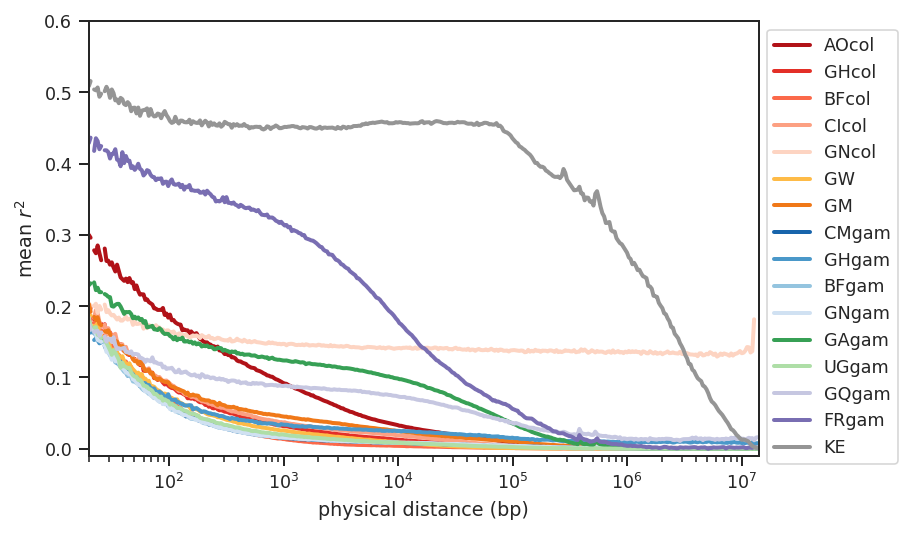

In [15]:
x = plot_ld_decay_lr(region_3R_free, path="../artwork/ld_decay.jpeg")